In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class ProphetForecastingPipeline:
    def __init__(self):
        self.model = None
        self.metrics = {}
        self.train_data = None
        self.validation_data = None
        
    def prepare_data(self, df):
        """
        Prepare data with specific split for 2025 validation and forecast
        """
        logger.info("Preparing data...")
        
        # Convert date and rename columns for Prophet
        df['Date'] = pd.to_datetime(df['Date'])
        prophet_df = df.rename(columns={
            'Date': 'ds',
            'Sales': 'y'
        })
        
        # Define key dates
        validation_start = '2025-01-01'
        validation_end = '2025-09-05'
        forecast_end = '2025-12-31'
        
        # Split data
        self.train_data = prophet_df[prophet_df['ds'] < validation_start].copy()
        self.validation_data = prophet_df[
            (prophet_df['ds'] >= validation_start) & 
            (prophet_df['ds'] <= validation_end)
        ].copy()
        
        # Create future dates dataframe for full 2025
        future_dates = pd.date_range(
            start=validation_start,
            end=forecast_end,
            freq='D'
        )
        self.future_df = pd.DataFrame({'ds': future_dates})
        
        logger.info(f"Training data shape: {self.train_data.shape}")
        logger.info(f"Validation data shape: {self.validation_data.shape}")
        logger.info(f"Future prediction periods: {len(self.future_df)}")
        
        return self.train_data, self.validation_data, self.future_df
    
    def train_model(self):
        """Train Prophet model with optimized parameters"""
        logger.info("Training Prophet model...")
        
        self.model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=True,
            seasonality_mode='multiplicative',
            seasonality_prior_scale=10,  # Flexibility for seasonal patterns
            changepoint_prior_scale=0.05  # Flexibility for trend changes
        )
        
        # Add country-specific holidays
        self.model.add_country_holidays(country_name='IE')
        
        self.model.fit(self.train_data)
        logger.info("Model training completed")
    
    def make_predictions(self):
        """Generate forecasts for both validation and future periods"""
        logger.info("Generating predictions...")
        
        # Get predictions for entire 2025
        predictions = self.model.predict(self.future_df)
        
        # Split predictions into validation and future periods
        validation_predictions = predictions[
            predictions['ds'] <= '2025-09-05'
        ]
        future_predictions = predictions[
            predictions['ds'] > '2025-09-05'
        ]
        
        return validation_predictions, future_predictions
    
    def evaluate_model(self, validation_predictions):
        """Calculate performance metrics for validation period"""
        actual = self.validation_data['y']
        predicted = validation_predictions['yhat']
        
        self.metrics = {
            'MAE': mean_absolute_error(actual, predicted),
            'RMSE': np.sqrt(mean_squared_error(actual, predicted)),
            'R2': r2_score(actual, predicted),
            'MAPE': np.mean(np.abs((actual - predicted) / actual)) * 100
        }
        
        logger.info("Model evaluation completed")
        return self.metrics
    
    def plot_results(self, validation_predictions, future_predictions):
        """Create comprehensive visualization of results"""
        plt.figure(figsize=(15, 10))
        
        # Plot training data
        plt.plot(self.train_data['ds'], self.train_data['y'], 
                label='Historical Data', color='gray', alpha=0.5)
        
        # Plot validation period
        plt.plot(self.validation_data['ds'], self.validation_data['y'],
                label='Actual (Validation)', color='black')
        plt.plot(validation_predictions['ds'], validation_predictions['yhat'],
                label='Predicted (Validation)', color='blue')
        
        # Plot future predictions
        plt.plot(future_predictions['ds'], future_predictions['yhat'],
                label='Future Forecast', color='red', linestyle='--')
        
        # Add confidence intervals
        plt.fill_between(
            future_predictions['ds'],
            future_predictions['yhat_lower'],
            future_predictions['yhat_upper'],
            color='red', alpha=0.1,
            label='Forecast Confidence Interval'
        )
        
        # Customize plot
        plt.title('Sales Forecast: 2025 Full Year')
        plt.xlabel('Date')
        plt.ylabel('Sales')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        
        # Add vertical lines to separate periods
        plt.axvline(x=pd.to_datetime('2025-01-01'), color='gray', 
                   linestyle='--', alpha=0.5)
        plt.axvline(x=pd.to_datetime('2025-09-05'), color='gray', 
                   linestyle='--', alpha=0.5)
        
        plt.tight_layout()
        plt.show()
        
        # Export predictions to CSV
        validation_predictions.to_csv('validation_predictions_2025.csv', index=False)
        future_predictions.to_csv('future_predictions_2025.csv', index=False)

INFO:__main__:Preparing data...
INFO:__main__:Training data shape: (1827, 4)
INFO:__main__:Validation data shape: (248, 4)
INFO:__main__:Future prediction periods: 365
INFO:__main__:Training Prophet model...
DEBUG:cmdstanpy:input tempfile: /var/folders/d1/9k4sfgrj4r5_v152pb8ny7xc0000gn/T/tmp0ud_ua_s/no2k9tmb.json
DEBUG:cmdstanpy:input tempfile: /var/folders/d1/9k4sfgrj4r5_v152pb8ny7xc0000gn/T/tmp0ud_ua_s/87h1uph0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/xxxxxxxx/venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40366', 'data', 'file=/var/folders/d1/9k4sfgrj4r5_v152pb8ny7xc0000gn/T/tmp0ud_ua_s/no2k9tmb.json', 'init=/var/folders/d1/9k4sfgrj4r5_v152pb8ny7xc0000gn/T/tmp0ud_ua_s/87h1uph0.json', 'output', 'file=/var/folders/d1/9k4sfgrj4r5_v152pb8ny7xc0000gn/T/tmp0ud_ua_s/prophet_model9ic86ibp/prophet_model-20241208163334.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:33:


Model Performance Metrics:
--------------------------------------------------
MAE: 4799.16
RMSE: 6160.38
R2: -0.02
MAPE: nan


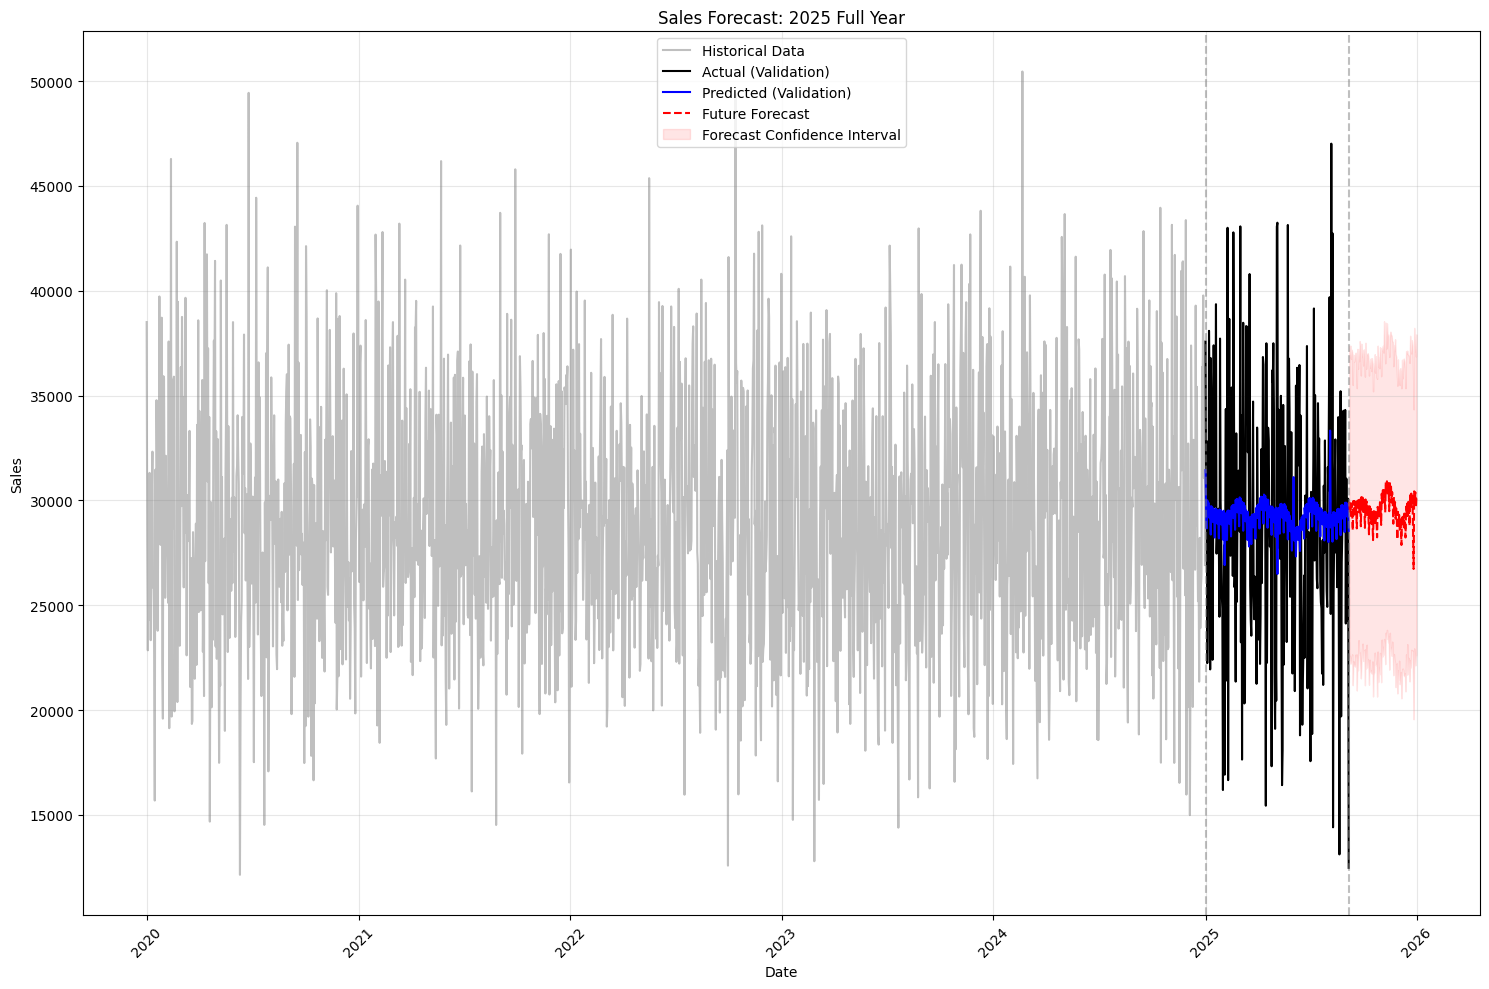

In [4]:
# Execute the pipeline
if __name__ == "__main__":
    # Load data
    data_path = 'xxxxxxxxxx'
    sales_data = pd.read_csv(data_path)
    
    # Initialize pipeline
    prophet_pipeline = ProphetForecastingPipeline()
    
    # Prepare data
    train_data, validation_data, future_df = prophet_pipeline.prepare_data(sales_data)
    
    # Train model
    prophet_pipeline.train_model()
    
    # Make predictions
    validation_predictions, future_predictions = prophet_pipeline.make_predictions()
    
    # Evaluate model
    metrics = prophet_pipeline.evaluate_model(validation_predictions)
    
    # Print metrics
    print("\nModel Performance Metrics:")
    print("-" * 50)
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}")
    
    # Plot results
    prophet_pipeline.plot_results(validation_predictions, future_predictions)